In [ ]:
from numpy import load, zeros, ones
from numpy.random import randint
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, LeakyReLU
from matplotlib import pyplot
from os import listdir
from numpy import asarray, vstack
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from numpy import savez_compressed
from keras.models import load_model

In [ ]:
# Функция разбивающее исходное изображение на снимок со спутника и фрагмент карты

def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	for filename in listdir(path):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		sat_img, map_img = pixels[:, 256:], pixels[:, :256]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

In [ ]:
path = 'maps/train/'
[src_images, tar_images] = load_images(path)
print('Загружено: ', src_images.shape, tar_images.shape)
# Сохранение загруженных изображений
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)

Загружено:  (1096, 256, 256, 3) (1096, 256, 256, 3)


In [ ]:
from numpy import load
from matplotlib import pyplot
# Загрузка изображений из сохраненного файла
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']

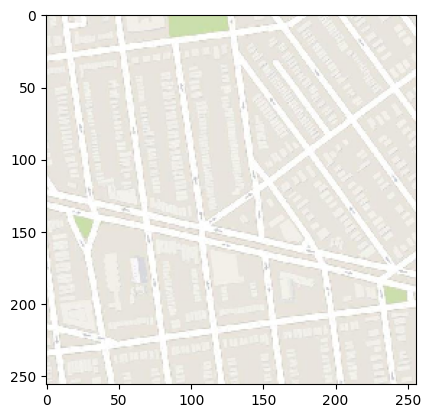

In [ ]:
pyplot.imshow(src_images[0].astype('uint8'))

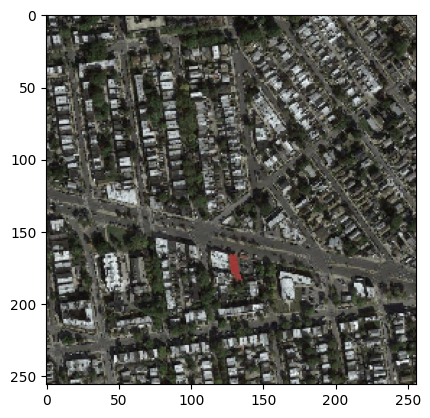

In [ ]:
pyplot.imshow(tar_images[0].astype('uint8'))

In [ ]:
def define_discriminator(image_shape): # Определение дискриминатора
	# инициализация весов
	init = RandomNormal(stddev=0.02)

	in_src_image = Input(shape=image_shape) # Входные слои для исходного и целевого изображений
	in_target_image = Input(shape=image_shape)
	merged = Concatenate()([in_src_image, in_target_image]) # Объединение исходного и целевого изображений

	# Сверточные слои	
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	 # Слои классификации
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)

	# Определение модели
	model = Model([in_src_image, in_target_image], patch_out)

	model.compile(loss='binary_crossentropy', optimizer='adam', loss_weights=[0.5])
	return model

In [ ]:
# Определение функции кодировщика
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# Определение функции декодера
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	g = BatchNormalization()(g, training=True)
	if dropout:
		g = Dropout(0.5)(g, training=True)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

In [ ]:
# генератор
def define_generator(image_shape=(256,256,3)):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)

	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
 
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)

	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)

	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)

	model = Model(in_image, out_image)
	model.compile(loss='binary_crossentropy', optimizer='adam', loss_weights=[0.5])
	return model

In [ ]:
# Создаём GAN
def define_gan(g_model, d_model, image_shape):
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False

	in_src = Input(shape=image_shape)
	gen_out = g_model(in_src)
	dis_out = d_model([in_src, gen_out])
	model = Model(in_src, [dis_out, gen_out])

	model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', loss_weights=[1,100])
	return model

In [ ]:
# Загружаем изображения и масштабируем к [-1,1]
def load_real_samples(filename):
	data = load(filename)
	X1, X2 = data['arr_0'], data['arr_1']
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape): #генерация реальных изображений
	trainA, trainB = dataset
	ix = randint(0, trainA.shape[0], n_samples)
	X1, X2 = trainA[ix], trainB[ix]
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# Промежуточное сохранение генераторов и генерированных изображений
def summarize_performance(step, g_model, dataset, n_samples=3):
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# Рисуем оригинальное
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# Рисуем сгенерированное
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# Рисуем целевое
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()

	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
import sys
#Обучение GAN модели
def train(d_model, g_model, gan_model, dataset, n_epochs=20, n_batch=1):
	n_patch = d_model.output_shape[1]
	trainA, trainB = dataset
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
		# Собираем набор реальных образцов
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# Собираем набор фэйковых образцов
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# Обновляем дискриминатор для реальной выборки
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# Обновляем дискриминатор для сгенерированной выборки
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# Обновляем генератор
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

		print(str( i+ 1 ) + '/' + str(n_steps))
		if (i+1) % (bat_per_epo) == 0:
			print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
			summarize_performance(i, g_model, dataset)

In [ ]:
dataset = load_real_samples('maps_256.npz') # Загрузка исходных и целевых изображений
image_shape = dataset[0].shape[1:]

d_model = define_discriminator(image_shape) # Определение модели дискриминатора
g_model = define_generator(image_shape) # Определение модели генератора

gan_model = define_gan(g_model, d_model, image_shape) # Определение модели GAN

In [ ]:
train(d_model, g_model, gan_model, dataset) # Обучение GAN модели

1/21920
2/21920
3/21920
4/21920
5/21920
6/21920
7/21920
8/21920
9/21920
10/21920
11/21920
12/21920
13/21920
14/21920
15/21920
16/21920
17/21920
18/21920
19/21920
20/21920
21/21920
22/21920
23/21920
24/21920
25/21920
26/21920
27/21920
28/21920
29/21920
30/21920
31/21920
32/21920
33/21920
34/21920
35/21920
36/21920
37/21920
38/21920
39/21920
40/21920
41/21920
42/21920
43/21920
44/21920
45/21920
46/21920
47/21920
48/21920
49/21920
50/21920
51/21920
52/21920
53/21920
54/21920
55/21920
56/21920
57/21920
58/21920
59/21920
60/21920
61/21920
62/21920
63/21920
64/21920
65/21920
66/21920
67/21920
68/21920
69/21920
70/21920
71/21920
72/21920
73/21920
74/21920
75/21920
76/21920
77/21920
78/21920
79/21920
80/21920
81/21920
82/21920
83/21920
84/21920
85/21920
86/21920
87/21920
88/21920
89/21920
90/21920
91/21920
92/21920
93/21920
94/21920
95/21920
96/21920
97/21920
98/21920
99/21920
100/21920
101/21920
102/21920
103/21920
104/21920
105/21920
106/21920
107/21920
108/21920
109/21920
110/21920
111/2192

In [ ]:
[X1, X2] = load_real_samples('maps_256.npz')
src_image, tar_image = X1[[0]], X2[[0]]

In [ ]:
model = load_model('model_021920.h5') # Загрузка модели
gen_image = model.predict(src_image) # Генерация изображения

In [ ]:
def plot_img(img):
  image = vstack((img))
  image = (image + 1) / 2.0
  pyplot.imshow(image)

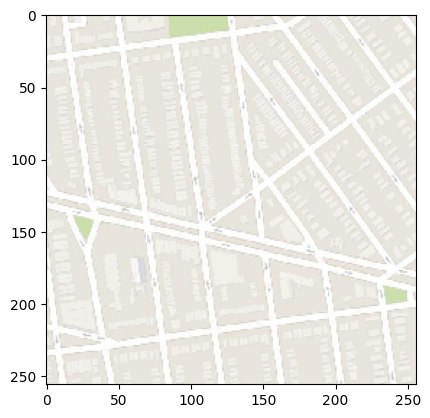

In [ ]:
plot_img(src_image)

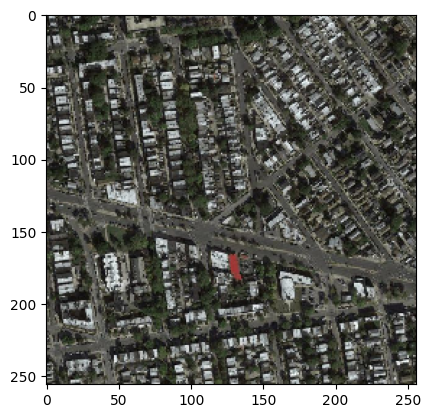

In [ ]:
plot_img(tar_image)

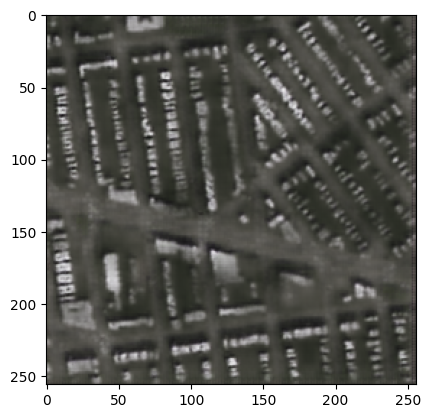

In [ ]:
plot_img(gen_image)

In [ ]:
src_image1, tar_image1 = X1[[1]], X2[[1]]
gen_image1 = model.predict(src_image1)

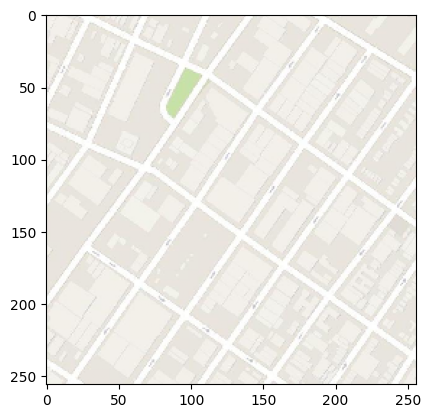

In [ ]:
plot_img(src_image1)

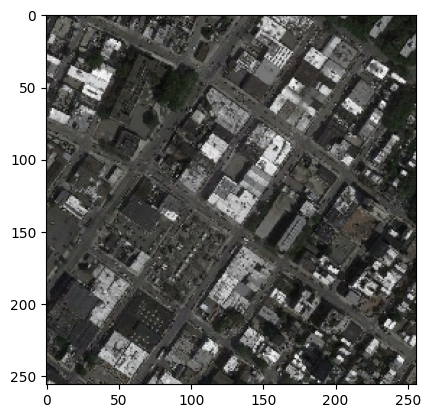

In [ ]:
plot_img(tar_image1)

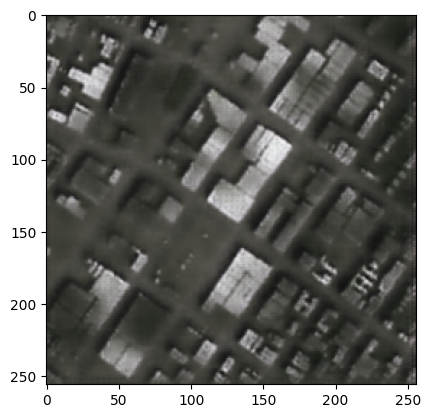

In [ ]:
plot_img(gen_image1)